In [1]:
# CSCB Final Project

# ! pip install scanpy python-igraph leidenalg
# !pip install --upgrade ipywidgets
# !pip install --upgrade session_info
# !pip install scanpy scipy numpy umap-learn leidenalg
# !pip install matplotlib scikit-learn

import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# install pybiomart
try:
    from pybiomart import Server
    BIOMART_AVAILABLE = True
except ImportError:
    BIOMART_AVAILABLE = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1

In [73]:
def select_control_mask(adata, obs_key: str, control_values):
    """
    Build a boolean mask selecting control (diploid) cells:
      obs_key       – name of a column in adata.obs
      control_values – value or list of values to treat as 'diploid'
    Returns: mask (pd.Series of bool)
    """
    vals = control_values if isinstance(control_values, (list,tuple)) else [control_values]
    return adata.obs[obs_key].isin(vals)


def ensure_gene_coords(adata, gtf_df: pd.DataFrame=None):
    """
    1. If 'chromosome','start','end' are present in adata.var, do nothing.
    2. Else merge with user‑supplied gtf_df.
    3. Else fetch missing via pybiomart (if installed).
    Drops any genes still lacking coords.
    """
    var = adata.var.copy()
    needed = {'chromosome','start','end'} - set(var.columns)
    if not needed:
        return adata

    # try GTF
    if gtf_df is not None:
        merged = var.merge(
            gtf_df[['gene_name','chrom','start','end']],
            left_index=True, right_on='gene_name', how='left'
        ).set_index(var.index)
        for src,dst in [('chrom','chromosome'),('start','start'),('end','end')]:
            adata.var[dst] = merged[src]

    # fetch missing via BioMart
    missing = adata.var['chromosome'].isna()
    if missing.any() and BIOMART_AVAILABLE:
        server = Server()
        ds = server.marts["ENSEMBL_MART_ENSEMBL"].datasets["hsapiens_gene_ensembl"]
        bm = ds.query(
            attributes=['external_gene_name','chromosome_name','start_position','end_position'],
            filters={'external_gene_name': list(adata.var_names[missing])}
        )
        bm = bm.rename(columns={
            'external_gene_name':'gene_name',
            'chromosome_name':'chrom',
            'start_position':'start',
            'end_position':'end'
        })
        merged2 = adata.var.merge(bm, left_index=True, right_on='gene_name', how='left').set_index(var.index)
        for src,dst in [('chrom','chromosome'),('start','start'),('end','end')]:
            adata.var[dst] = merged2[src].fillna(adata.var[dst])

    # drop genes still missing coords
    to_drop = adata.var['chromosome'].isna()
    if to_drop.any():
        adata = adata[:, ~to_drop].copy()

    return adata


################## 新改的，改成log 2 ratio了
def normalize_expr(adata, control_adata, method='log2_ratio'):  # ← default now 'log2_ratio'
    """
    Gene‐specific normalization against diploid control:
      - 'log2_ratio':  log2((X+1)/(μ+1))
    """
    Xc_raw = control_adata.X
    Xc = Xc_raw.toarray() if sp.issparse(Xc_raw) else np.array(Xc_raw)
    mu = Xc.mean(axis=0)

    X_raw = adata.X
    X = X_raw.toarray() if sp.issparse(X_raw) else np.array(X_raw)

    if method == 'log2_ratio':
        return np.log2((X + 1) / (mu + 1))
    else:
        raise ValueError(f"Only 'log2_ratio' is supported. Got: {method}")
#################################### 改动到这里结束

def sliding_window_segments(Z, var_df, window=50, gain_thr=0.2, loss_thr=-0.2):
    segments = []
    var = var_df.copy()
    var['gene_idx'] = np.arange(len(var))

    for chrom, sub in var.groupby('chromosome'):
        sub = sub.sort_values('start')
        idxs = sub['gene_idx'].values
        avg  = Z[:, idxs].mean(axis=0)
        mv   = pd.Series(avg).rolling(window, center=True, min_periods=1).mean().values

        state = np.zeros_like(mv, int)
        state[mv>=gain_thr] =  1
        state[mv<=loss_thr] = -1

        prev = state[0]; start_i = 0
        for i, s in enumerate(state[1:], start=1):
            if s != prev:
                if prev!=0:
                    segments.append({
                        'chrom': chrom,
                        'start': int(sub.iloc[start_i]['start']),
                        'end':   int(sub.iloc[i-1]['end']),
                        'type':  'gain' if prev>0 else 'loss'
                    })
                start_i = i; prev = s
        if prev!=0:
            segments.append({
                'chrom': chrom,
                'start': int(sub.iloc[start_i]['start']),
                'end':   int(sub.iloc[len(state)-1]['end']),
                'type':  'gain' if prev>0 else 'loss'
            })

    return segments


class CNAInferer:
    def __init__(self,
                 adata,
                 control_adata,
                 gtf_df: pd.DataFrame=None,
                 window=50,
                 gain_thr=0.2,
                 loss_thr=-0.2,
                 norm_method='log2_ratio'):
        # 1) ensure coords
        self.adata = ensure_gene_coords(adata.copy(), gtf_df)
        # 2) align control
        self.control = control_adata[:, self.adata.var_names].copy()
        # 3) params
        self.window      = window
        self.gain_thr    = gain_thr
        self.loss_thr    = loss_thr
        self.norm_method = norm_method

    import numpy as np
    import gc

    def infer(self):
        # Normalize expression (row-wise normalization preferred)
        Z = normalize_expr(self.adata, self.control, method=self.norm_method)

        # Convert to float32 for memory savings
        if Z.dtype != np.float32:
            Z = Z.astype(np.float32, copy=False)

        # Segment genome (runs only once)
        segs = sliding_window_segments(
            Z,
            self.adata.var[['chromosome', 'start', 'end']],
            window=self.window,
            gain_thr=self.gain_thr,
            loss_thr=self.loss_thr
        )
        self.adata.uns['cna_segments'] = segs

        # Precompute segment-gene indices only once
        chrom = self.adata.var['chromosome'].to_numpy()
        start = self.adata.var['start'].to_numpy()
        end = self.adata.var['end'].to_numpy()

        segment_gene_indices = []
        for seg in segs:
            mask = (chrom == seg['chrom']) & (start >= seg['start']) & (end <= seg['end'])
            idxs = np.flatnonzero(mask)
            segment_gene_indices.append(idxs)

        # Free variables not needed anymore
        del chrom, start, end
        gc.collect()

        # Write CNA profiles in chunks to avoid high memory usage
        n_cells = Z.shape[0]
        batch_size = 500  # adjust to fit memory constraints
        profile_chunks = []

        for i in range(0, n_cells, batch_size):
            batch_profiles = []
            Z_batch = Z[i:i + batch_size]  # get only current batch

            for ci in range(Z_batch.shape[0]):
                calls = []
                for seg, idxs in zip(segs, segment_gene_indices):
                    subz = Z_batch[ci, idxs]
                    if subz.size and (
                        (seg['type'] == 'gain' and subz.mean() > 0) or
                        (seg['type'] == 'loss' and subz.mean() < 0)
                    ):
                        calls.append(f"{seg['chrom']}:{seg['start']}-{seg['end']}({seg['type']})")
                batch_profiles.append(";".join(calls))

            profile_chunks.extend(batch_profiles)

            # Clean up
            del Z_batch, batch_profiles
            gc.collect()

        # Store the final profile list
        self.adata.obs['cna_profile'] = profile_chunks

        return self.adata



# Replace your old test_pipeline_on_slice with this:

def test_pipeline_on_slice(
    adata,
    obs_key_control: str,
    control_values,
    obs_key_test: str,
    test_values,
    chromosome: str,
    gtf_df: pd.DataFrame = None,
    window: int = 20,
    gain_thr: float = 0.2,
    loss_thr: float = -0.2,
    norm_method: str = 'log2_ratio'
):
    """
    1) Pick control cells via adata.obs[obs_key_control] ∈ control_values
    2) Pick test  cells via adata.obs[obs_key_test]    ∈  test_values
    3) Subset genes on `chromosome`
    4) Run CNAInferer on that slice
    """
    # build masks
    ctrl_mask = adata.obs[obs_key_control].isin(control_values)
    tst_mask  = adata.obs[obs_key_test]   .isin(test_values)

    # subset
    ctrl = adata[ctrl_mask].copy()
    sub  = adata[tst_mask].copy()
    # keep only genes on the desired chromosome
    sub  = sub[:, sub.var['chromosome'] == chromosome].copy()
    ctrl = ctrl[:, sub.var_names].copy()

    # infer
    inferer = CNAInferer(
        adata        = sub,
        control_adata= ctrl,
        gtf_df       = gtf_df,
        window       = window,
        gain_thr     = gain_thr,
        loss_thr     = loss_thr,
        norm_method  = norm_method
    )
    return inferer.infer()


<ipython-input-5-5ab45d17921e>:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


Called CNA segments:

Example per-cell profiles:
                                  simulated_cnvs cna_profile
AAACCCACAGAGTTGG-1   22:19807132-29743868 (CN 0)            
AAACGAAAGACGTCGA-1   22:19807132-29743868 (CN 0)            
AAACGAACACGACGTC-1  X:106533974-112956833 (CN 4)            
AAACGAAGTTATGTCG-1  X:106533974-112956833 (CN 4)            
AAACGCTAGAGGTTTA-1    6:25435484-35035259 (CN 1)            


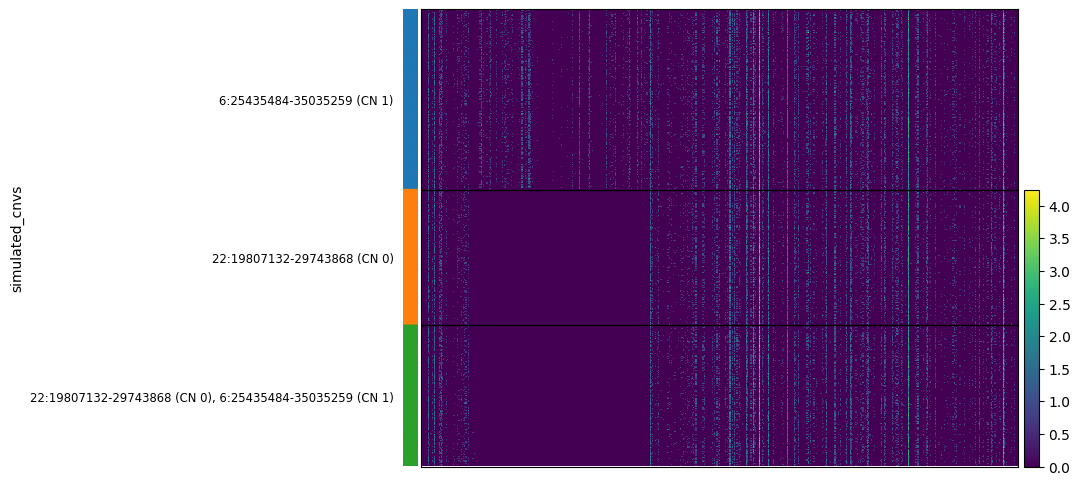

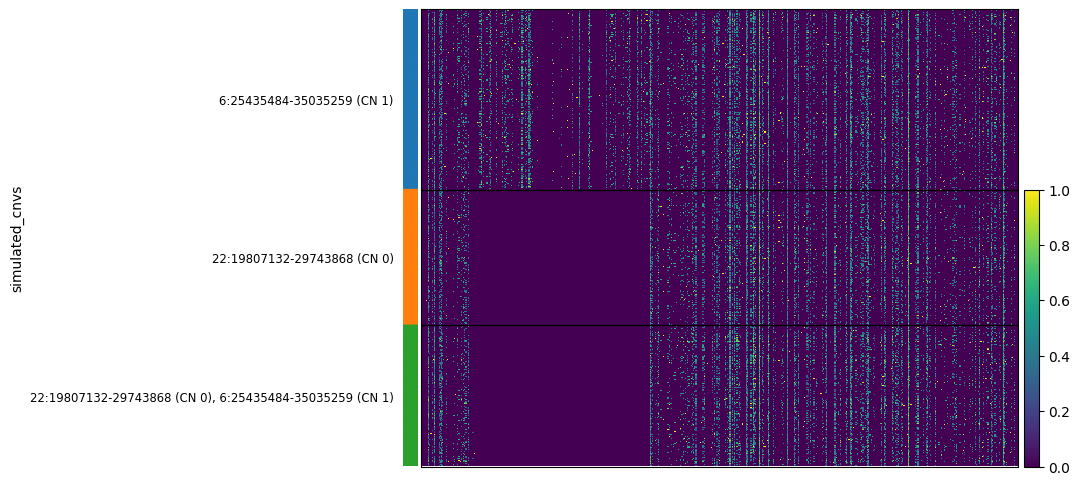

In [ ]:
# Testing

# 1) Load the data

adata = sc.read_h5ad("/content/drive/MyDrive/CSCB/processed_data/PBMC_simulated_cnas_041025.h5ad")

# 2) Define diploid control vs. test (any non‐diploid cell)
ctrl_mask = select_control_mask(adata, 'simulated_cnvs', [''])  # "" == diploid
control    = adata[ctrl_mask].copy()
test       = adata[~ctrl_mask].copy()

# 3) Run inference on all non-diploid cells
inferer = CNAInferer(
    adata         = test,
    control_adata = control,
    gtf_df        = None,      # coords already in this AnnData
    window        = 100,
    gain_thr      =  0.2,
    loss_thr      = -0.2,
    norm_method   = 'log2_ratio'
)
adata2 = inferer.infer()

# 4) Print called segments & a few per-cell profiles
print("Called CNA segments:")
for seg in adata2.uns['cna_segments']:
    print(f"  • Chr{seg['chrom']}:{seg['start']}-{seg['end']} → {seg['type']}")

print("\nExample per-cell profiles:")
print(adata2.obs[['simulated_cnvs','cna_profile']].head())

# subset to CD14 monocytes and Chr 22
adMono = adata2[adata2.obs['cell_type'] == 'CD14 monocyte'].copy()
adChr22 = adMono[:, adMono.var['chromosome'] == '22'].copy()

# Raw counts on left
sc.pl.heatmap(adChr22, adChr22.var_names,
              groupby='simulated_cnvs',
              layer="counts",
              log=True)

# gene-scaled on right makes the CNA footprint more apparent
sc.pl.heatmap(adChr22, adChr22.var_names,
              groupby='simulated_cnvs',
              layer="counts",
              log=True,
              standard_scale='var')


In [ ]:
print(adata.obs)

                                           sample
AAACGAATCATAGGCT-1_Somitoid Day 1  Somitoid Day 1
AAACGAATCGCCATAA-1_Somitoid Day 1  Somitoid Day 1
AAACGCTCACATGACT-1_Somitoid Day 1  Somitoid Day 1
AAACGCTGTCGAGATG-1_Somitoid Day 1  Somitoid Day 1
AAACGCTTCGGAGTGA-1_Somitoid Day 1  Somitoid Day 1
...                                           ...
TTTGTTGCACTGATTG-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGCATCGGATT-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGTCCAAACCA-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGTCCAGTACA-1_Somitoid Day 5  Somitoid Day 5
TTTGTTGTCTAGTACG-1_Somitoid Day 5  Somitoid Day 5

[37432 rows x 1 columns]


Quantify cna to cell type

In [ ]:

# — assume your final AnnData from Task 1 is in `adata2` —
#   with .uns['cna_segments'] and .obs['cna_profile']

# 1) build unique segment IDs
segs = adata2.uns['cna_segments']
seg_ids = [
    f"{s['chrom']}:{s['start']}-{s['end']}({s['type']})"
    for s in segs
]

# 2) allocate binary matrix
n_cells = adata2.n_obs
n_segs  = len(seg_ids)
mat     = np.zeros((n_cells, n_segs), dtype=int)

# map seg‐string → column idx
col_map = {seg: i for i,seg in enumerate(seg_ids)}

# 3) fill matrix from cna_profile
for i, prof in enumerate(adata2.obs['cna_profile']):
    if prof:
        for seg in prof.split(';'):
            j = col_map.get(seg)
            if j is not None:
                mat[i, j] = 1

# 4) stash in .obsm
adata2.obsm['cna_matrix']     = mat
adata2.uns['cna_segment_ids'] = seg_ids

# 5) per‐cell CNA burden
burden = mat.sum(axis=1)
adata2.obs['cna_burden'] = burden

# 6) per‐group CNA burden (e.g. by cell_type)
groupby = 'cell_type'  # or any obs‐column you like
group_burden = (
    adata2.obs
    .groupby(groupby)['cna_burden']
    .agg(['mean','median','count'])
    .rename(columns={'count':'n_cells'})
)
adata2.uns['cna_group_burden'] = group_burden

# 7) quick printouts
print("Per‐cell CNA burden (first 5 cells):")
print(adata2.obs['cna_burden'].head())

print("\nPer‐group CNA burden summary:")
print(group_burden)


# Task 2

In [ ]:
# Task 2A: Access Performance
# ========================
# Install necessary packages
# ========================
# !pip install scanpy python-igraph leidenalg umap-learn scFates matplotlib scikit-learn

# ========================
# Imports
# ========================
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Also import your CNA inference code here
# (Assume you have CNAInferer, select_control_mask, etc. defined above)

# ========================
# Load data
# ========================
# # If your file is on your Google Drive, mount it
# from google.colab import drive
# drive.mount('/content/drive')

# # Example: Adjust this to your file path
# adata_full = sc.read_h5ad("/content/drive/MyDrive/your_folder/PBMC_simulated_cnas_041025.h5ad")

# ========================
# Define evaluation functions
# ========================
def evaluate_cna_call(adata, truth_col='simulated_cnvs', pred_col='cna_profile'):
    y_true = adata.obs[truth_col].apply(lambda x: 0 if x=='' else 1)
    y_pred = adata.obs[pred_col].apply(lambda x: 0 if x=='' else 1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

def run_cna_evaluation(adata, control, params):
    inferer = CNAInferer(
        adata         = adata.copy(),
        control_adata = control.copy(),
        gtf_df        = None,
        window        = params['window'],
        gain_thr      = params['gain_thr'],
        loss_thr      = params['loss_thr'],
        norm_method   = params['norm_method']
    )
    adata2 = inferer.infer()
    metrics = evaluate_cna_call(adata2)
    return metrics

# ========================
# Prepare control vs test cells
# ========================
ctrl_mask = select_control_mask(adata, 'simulated_cnvs', [''])
control    = adata[ctrl_mask].copy()
test       = adata[~ctrl_mask].copy()

# ========================
# Parameter Grid Search
# ========================
param_grid = [
    {'window': w, 'gain_thr': g, 'loss_thr': -g, 'norm_method': n}
    for w in [20, 50, 100]
    for g in [0.2, 0.4]
    for n in ['zscore', 'log2_ratio']
]

results = []
for params in param_grid:
    print(f"Evaluating {params}")
    metrics = run_cna_evaluation(test, control, params)
    results.append({**params, **metrics})

results_df = pd.DataFrame(results)
print(results_df)

# ========================
# Plot F1 vs Window Size
# ========================
for norm_method in ['zscore', 'log2_ratio']:
    subset = results_df[results_df['norm_method'] == norm_method]
    plt.figure()
    for gthr in subset['gain_thr'].unique():
        subsub = subset[subset['gain_thr'] == gthr]
        plt.plot(subsub['window'], subsub['f1'], marker='o', label=f"gain_thr={gthr}")
    plt.title(f"F1 vs Window Size ({norm_method})")
    plt.xlabel("Window Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# ========================
# Explore Impact of Read Depth
# ========================
downsample_rates = [0.9, 0.5, 0.1]
downsample_results = []

for rate in downsample_rates:
    print(f"Downsampling to {rate*100:.0f}% reads")
    adata_ds = adata.copy()
    sc.pp.downsample_counts(adata_ds, counts_per_cell=int(adata_ds.X.sum(1).A1.mean() * rate))

    ctrl_mask = select_control_mask(adata_ds, 'simulated_cnvs', [''])
    control_ds = adata_ds[ctrl_mask].copy()
    test_ds    = adata_ds[~ctrl_mask].copy()

    best_params = {'window': 40, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}
    metrics = run_cna_evaluation(test_ds, control_ds, best_params)
    downsample_results.append({'read_depth': rate, **metrics})

downsample_df = pd.DataFrame(downsample_results)
print(downsample_df)

# ========================
# Plot Read Depth vs F1
# ========================
plt.figure()
plt.plot(downsample_df['read_depth'], downsample_df['f1'], marker='o')
plt.xlabel("Fraction of Original Read Depth")
plt.ylabel("F1 Score")
plt.title("Effect of Read Depth on CNA Inference")
plt.gca().invert_xaxis()  # higher read depth on left
plt.grid(True)
plt.show()


Evaluating {'window': 20, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'zscore'}


ValueError: Only 'log2_ratio' is supported. Got: zscore

# Modified Task 3

In [74]:
import scanpy as sc
import numpy as np
import anndata as ad
import gc

def prepare_control(adata, time_key='timepoint', ctrl_label='D0', min_genes=200, n_subsample=500):
    ctrl_mask = adata.obs[time_key] == ctrl_label
    control = adata[ctrl_mask].copy()
    
    # Optional: filter low-quality cells
    sc.pp.filter_cells(control, min_genes=min_genes)
    
    # Subsample to reduce size
    if control.n_obs > n_subsample:
        idx = np.random.choice(control.n_obs, n_subsample, replace=False)
        control = control[idx]
    
    return control

def infer_cna_by_timepoint(adata, control, gtf_df=None, time_key='timepoint', exclude=['D0'], gain_thr=0.1, loss_thr=-0.5, window=30):
    results = []
    timepoints = sorted(set(adata.obs[time_key]) - set(exclude))

    for tp in timepoints:
        print(f"[INFO] Inferring CNAs for {tp}...")
        tp_mask = adata.obs[time_key] == tp
        test = adata[tp_mask].copy()
        
        inferer = CNAInferer(test, control, gtf_df=gtf_df, gain_thr=gain_thr, loss_thr=loss_thr, window=window, norm_method='log2_ratio')
        inferred = inferer.infer()
        results.append(inferred)

    # Combine all inferred AnnData
    combined = ad.concat(results, join='outer', index_unique=None)
    return combined




## dataset 3

In [75]:
adata3 = sc.read_h5ad("../data/num3_adata_filtered.h5ad")

print(adata3.obs.columns)

Index(['timepoint', 'assay', 'batch', 'cell_type'], dtype='object')


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [87]:
control = prepare_control(adata3, time_key='timepoint', ctrl_label='D0')
cna_results = infer_cna_by_timepoint(adata3, 
                                     control, 
                                     gtf_df=None, 
                                     time_key='timepoint', 
                                     exclude=['D0'], 
                                     gain_thr=0.1, 
                                     loss_thr=-0.45, window=30)

/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[INFO] Inferring CNAs for D10...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D2...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D4...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D6...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D8...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [90]:
cna_results.obs['cna_profile'].unique()

array(['HSCHR2_6_CTG1:59578-236573(loss)',
       'HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG4:59734-259895(loss)',
       'HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG4:59734-259895(loss);HSCHR22_1_CTG5:21471-101331(gain)',
       'HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG5:21471-101331(gain)',
       'HSCHR22_1_CTG4:59734-259895(loss);HSCHR22_1_CTG5:21471-101331(gain)',
       '', 'HSCHR22_1_CTG5:21471-101331(gain)',
       'HSCHR22_1_CTG4:59734-259895(loss)',
       'HSCHR2_6_CTG1:59578-236573(loss);HSCHR21_6_CTG1_1:451-9253(gain)',
       'HSCHR2_6_CTG1:59578-236573(loss);HSCHR7_3_CTG6:2415-204593(gain)',
       'HSCHR2_6_CTG1:59578-236573(loss);HSCHR7_3_CTG6:2415-204593(gain);HSCHR21_6_CTG1_1:451-9253(gain)',
       'HSCHR7_3_CTG6:2415-204593(gain)',
       'HSCHR7_3_CTG6:2415-204593(gain);HSCHR21_6_CTG1_1:451-9253(gain)',
       'HSCHR21_6_CTG1_1:451-9253(gain)'], dtype=object)

In [91]:
cna_results.obs['cna_profile'].value_counts()

cna_profile
HSCHR2_6_CTG1:59578-236573(loss)                                                                        122065
HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG4:59734-259895(loss)                                       68738
                                                                                                         10707
HSCHR2_6_CTG1:59578-236573(loss);HSCHR7_3_CTG6:2415-204593(gain)                                         10355
HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG4:59734-259895(loss);HSCHR22_1_CTG5:21471-101331(gain)      9114
HSCHR2_6_CTG1:59578-236573(loss);HSCHR7_3_CTG6:2415-204593(gain);HSCHR21_6_CTG1_1:451-9253(gain)          6786
HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG5:21471-101331(gain)                                        4034
HSCHR2_6_CTG1:59578-236573(loss);HSCHR21_6_CTG1_1:451-9253(gain)                                          3274
HSCHR22_1_CTG4:59734-259895(loss)                                                                   

In [92]:
cna_results.write_h5ad('../data/cna_profile_results/adata3_results.h5ad')

## dataset 5

In [97]:
adata5 = sc.read_h5ad("../data/num5_adata_filtered.h5ad")

print(adata5.obs.columns)

Index(['day', 'sample_day', 'cell_type'], dtype='object')


In [99]:
control5 = prepare_control(adata5, time_key='day', ctrl_label='d1')
cna_results5 = infer_cna_by_timepoint(adata5, control5, gtf_df=None, time_key='day', exclude=['d1'], gain_thr=0.2, loss_thr=-0.3, window=30)


[INFO] Inferring CNAs for d2...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for d3...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for d5...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


In [102]:
cna_results5.obs['cna_profile'].value_counts()

cna_profile
HSCHR7_3_CTG6:2415-204593(loss);HSCHR18_2_CTG2:152309-162707(loss)                                                                    6474
HG2521_PATCH:22400-130946(gain);HSCHR7_3_CTG6:2415-204593(loss);HSCHR18_2_CTG2:152309-162707(loss)                                    4426
HG2521_PATCH:22400-130946(gain);HSCHR6_1_CTG5:9444-271782(gain);HSCHR7_3_CTG6:2415-204593(loss);HSCHR18_2_CTG2:152309-162707(loss)    2885
HSCHR6_1_CTG5:9444-271782(gain);HSCHR7_3_CTG6:2415-204593(loss);HSCHR18_2_CTG2:152309-162707(loss)                                    1079
HG2521_PATCH:22400-130946(gain);HSCHR6_1_CTG5:9444-271782(gain);HSCHR7_3_CTG6:2415-204593(loss)                                        181
HG2521_PATCH:22400-130946(gain);HSCHR6_1_CTG5:9444-271782(gain);HSCHR18_2_CTG2:152309-162707(loss)                                     160
HG2521_PATCH:22400-130946(gain);HSCHR7_3_CTG6:2415-204593(loss)                                                                        116
HSCHR6_1_CTG5:9

In [100]:
cna_results5.write_h5ad('../data/cna_profile_results/adata5_results.h5ad')

## dataset 7

In [103]:
adata7 = sc.read_h5ad("../data/num7_adata_filtered.h5ad")

print(adata7.obs.columns)

Index(['sample', 'sample_id', 'cell_type'], dtype='object')


In [104]:
import re

# General cleaning: remove GSM prefix and .tar suffix
clean_ids = (
    adata7.obs['sample_id']
    .str.replace(r'^GSM\d+_', '', regex=True)  # removes variable GSM prefix
    .str.replace(r'\.tar$', '', regex=True)    # removes suffix
    .str.strip()
)

# Define the mapping
sample_to_timepoint = {
    'sample1_t1': "D0",
    'sample1_t2': "D1",
    'sample1_t3': "D2",
    'sample1_t4': "D3",
    'sample2_t1': "D4",
    'sample2_t2': "D5",
    'sample2_t3': "D6",
    'sample3_t1': "D7",
    'sample3_t2': "D8"
}

# Assign to .obs
adata7.obs['timepoint'] = clean_ids.map(sample_to_timepoint)
adata7.obs['clean_sample_id'] = clean_ids  # optional for inspection


In [105]:
control7 = prepare_control(adata7, time_key='timepoint', ctrl_label='D0')
cna_results7 = infer_cna_by_timepoint(adata7, control7, gtf_df=None, time_key='timepoint', exclude=['D0'], gain_thr=0.2, loss_thr=-0.3, window=30)


[INFO] Inferring CNAs for D1...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D2...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D3...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D4...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D5...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D6...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D7...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D8...


/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


In [106]:
cna_results7.obs['cna_profile'].value_counts()

cna_profile
HSCHR2_6_CTG1:59578-236573(loss)                                                                                                        3869
HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG4:59734-259895(gain)                                                                      3261
HSCHR2_6_CTG1:59578-236573(loss);HSCHR7_3_CTG6:2415-204593(gain);HSCHR18_2_CTG2:152309-162707(gain)                                     2209
HSCHR2_6_CTG1:59578-236573(loss);HSCHR19_2_CTG3_1:8674-30733(loss);HSCHR22_1_CTG4:59734-259895(gain)                                    2042
HSCHR2_6_CTG1:59578-236573(loss);HSCHR6_1_CTG5:9444-271782(gain);HSCHR18_2_CTG2:152309-162707(loss)                                     1826
HSCHR2_6_CTG1:59578-236573(loss);HSCHR18_2_CTG2:152309-162707(loss);HSCHR19_2_CTG3_1:8674-30733(loss)                                   1236
HSCHR2_6_CTG1:59578-236573(loss);HSCHR18_2_CTG2:152309-162707(loss)                                                                      993
H

In [107]:
num_gain = cna_results7.obs['cna_profile'].str.contains('gain').sum()
print(f"Number of items with 'gain': {num_gain}")

Number of items with 'gain': 12015


In [108]:
num_loss = cna_results7.obs['cna_profile'].str.contains('loss').sum()
print(f"Number of items with 'loss': {num_loss}")

Number of items with 'loss': 18990


In [109]:
cna_results7.write_h5ad('../data/cna_profile_results/adata7_results.h5ad')

# Visualization

## dataset3

In [2]:
cna_results3 = sc.read_h5ad("../data/cna_profile_results/adata3_results.h5ad")

c:\Users\clark\anaconda3\envs\OneSC_run\lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
cna_results3.obs

,timepoint,assay,batch,cell_type,cna_profile,cna_burden
AACACACAGAACGTCCAAGCATTAGCA,D10,scRNA-seq,D10_scRNA-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss),1
AACACACAGAACGTCCAAGTGTCTGAA,D10,scRNA-seq,D10_scRNA-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,2
AACACACAGAATCCGGTGAATTCTGGC,D10,scRNA-seq,D10_scRNA-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,3
AACACACAGACAACAGGTGTAACGCTT,D10,scRNA-seq,D10_scRNA-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,3
AACACACAGACACCAACGGATTGCGAG,D10,scRNA-seq,D10_scRNA-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,2
...,...,...,...,...,...,...
TGTGGACACTTACACGACGCATTAGCA,D8,Glycosylation-seq,D8_Glycosylation-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,2
TGTGGACACTTCGAGGATCAGGAACCA,D8,Glycosylation-seq,D8_Glycosylation-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,2
TGTGGACACTTCGAGGATCCATATCTC,D8,Glycosylation-seq,D8_Glycosylation-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,2
TGTGGACACTTGAGACAGCTAGGTTGC,D8,Glycosylation-seq,D8_Glycosylation-seq,unknown,HSCHR2_6_CTG1:59578-236573(loss);HSCHR22_1_CTG...,2


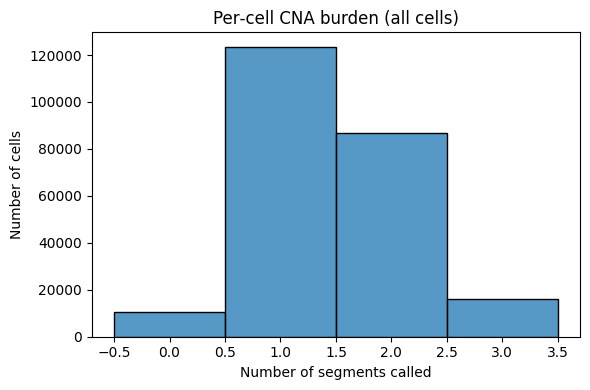

C:\Users\clark\AppData\Local\Temp\ipykernel_38244\2049404341.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cna_results3.obs, x='timepoint', y='cna_burden', palette='Set2')


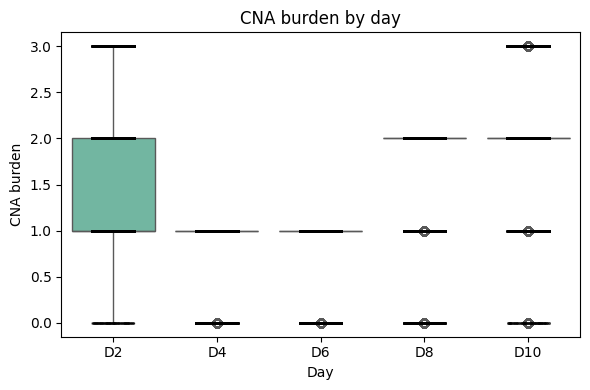

C:\Users\clark\AppData\Local\Temp\ipykernel_38244\2049404341.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette='mako')


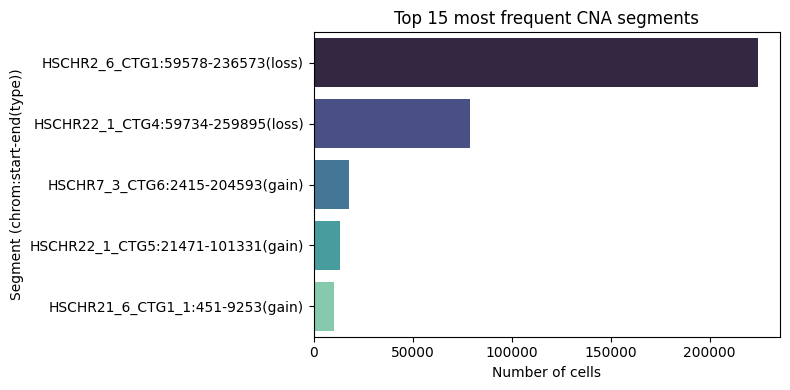

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# assume cna_results3 is your combined AnnData from infer_cna_by_timepoint(...)
# and has:
#  - .obs['day']       the timepoint label
#  - .obs['cna_profile']  a string like "Chr1:100-200(gain);Chr3:500-800(loss)"
#  - .uns['cna_segments'] a list of segment dicts (chrom,start,end,type)

# 1) compute per‑cell burden (# of segments)
def count_segments(profile):
    if not profile:
        return 0
    return len(profile.split(';'))

burden = cna_results3.obs['cna_profile'].fillna('').map(count_segments)
cna_results3.obs['cna_burden'] = burden

# 2) plot global burden histogram
plt.figure(figsize=(6,4))
sns.histplot(burden, bins=np.arange(burden.max()+2)-0.5, kde=False)
plt.title("Per‑cell CNA burden (all cells)")
plt.xlabel("Number of segments called")
plt.ylabel("Number of cells")
plt.tight_layout()
plt.show()

# 3) plot burden by timepoint
plt.figure(figsize=(6,4))
sns.boxplot(data=cna_results3.obs, x='timepoint', y='cna_burden', palette='Set2')
sns.stripplot(data=cna_results3.obs, x='timepoint', y='cna_burden',
              color='k', size=2, alpha=0.3, jitter=0.2)
plt.title("CNA burden by day")
plt.xlabel("Day")
plt.ylabel("CNA burden")
plt.tight_layout()
plt.show()

# 4) most frequent CNA segments across all cells
#    explode all the profiles into one long list
all_segs = (
    cna_results3.obs['cna_profile']
      .dropna()
      .loc[lambda s: s != ""]
      .str.split(';')
      .explode()
)
freq = all_segs.value_counts().head(15)

plt.figure(figsize=(8,4))
sns.barplot(x=freq.values, y=freq.index, palette='mako')
plt.title("Top 15 most frequent CNA segments")
plt.xlabel("Number of cells")
plt.ylabel("Segment (chrom:start-end(type))")
plt.tight_layout()
plt.show()


## dataset 5

In [8]:
cna_result5 = sc.read_h5ad("../data/cna_profile_results/adata5_results.h5ad")

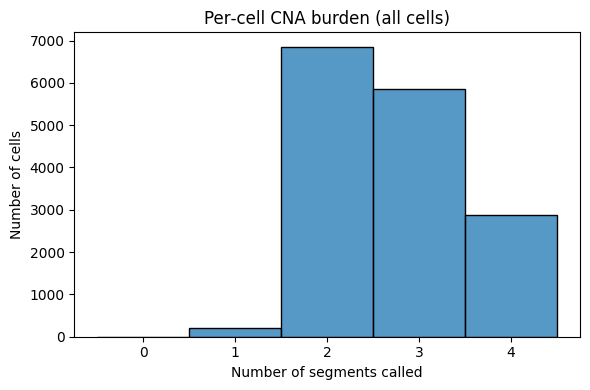

C:\Users\clark\AppData\Local\Temp\ipykernel_38244\2388969635.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cna_result5.obs, x='day', y='cna_burden', palette='Set2')


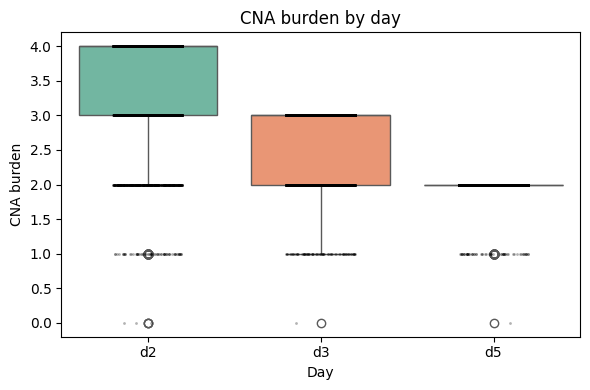

C:\Users\clark\AppData\Local\Temp\ipykernel_38244\2388969635.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette='mako')


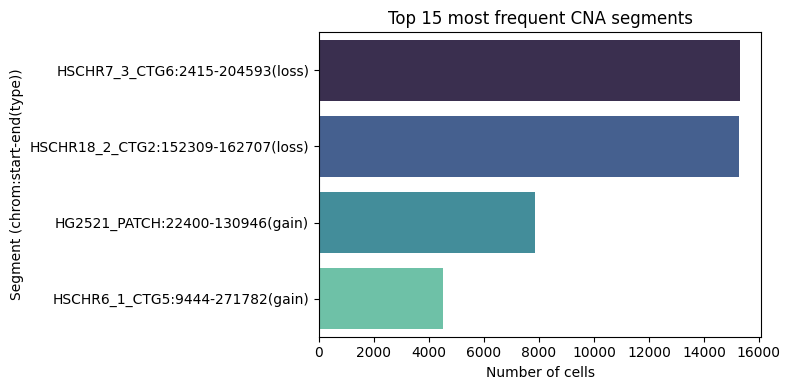

In [9]:

# assume cna_result5 is your combined AnnData from infer_cna_by_timepoint(...)
# and has:
#  - .obs['day']       the timepoint label
#  - .obs['cna_profile']  a string like "Chr1:100-200(gain);Chr3:500-800(loss)"
#  - .uns['cna_segments'] a list of segment dicts (chrom,start,end,type)

# 1) compute per‑cell burden (# of segments)
def count_segments(profile):
    if not profile:
        return 0
    return len(profile.split(';'))

burden = cna_result5.obs['cna_profile'].fillna('').map(count_segments)
cna_result5.obs['cna_burden'] = burden

# 2) plot global burden histogram
plt.figure(figsize=(6,4))
sns.histplot(burden, bins=np.arange(burden.max()+2)-0.5, kde=False)
plt.title("Per‑cell CNA burden (all cells)")
plt.xlabel("Number of segments called")
plt.ylabel("Number of cells")
plt.tight_layout()
plt.show()

# 3) plot burden by timepoint
plt.figure(figsize=(6,4))
sns.boxplot(data=cna_result5.obs, x='day', y='cna_burden', palette='Set2')
sns.stripplot(data=cna_result5.obs, x='day', y='cna_burden',
              color='k', size=2, alpha=0.3, jitter=0.2)
plt.title("CNA burden by day")
plt.xlabel("Day")
plt.ylabel("CNA burden")
plt.tight_layout()
plt.show()

# 4) most frequent CNA segments across all cells
#    explode all the profiles into one long list
all_segs = (
    cna_result5.obs['cna_profile']
      .dropna()
      .loc[lambda s: s != ""]
      .str.split(';')
      .explode()
)
freq = all_segs.value_counts().head(15)

plt.figure(figsize=(8,4))
sns.barplot(x=freq.values, y=freq.index, palette='mako')
plt.title("Top 15 most frequent CNA segments")
plt.xlabel("Number of cells")
plt.ylabel("Segment (chrom:start-end(type))")
plt.tight_layout()
plt.show()


## dataset 7

In [10]:
cna_result7 = sc.read_h5ad("../data/cna_profile_results/adata7_results.h5ad")

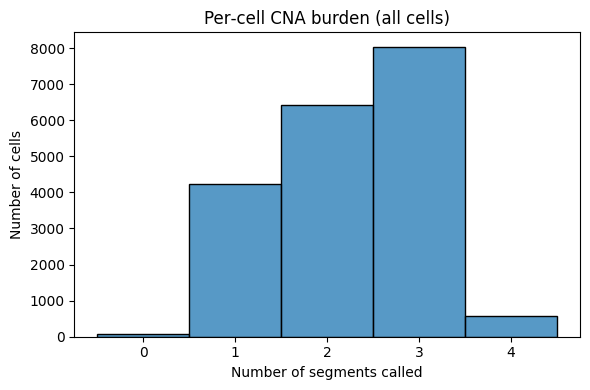

C:\Users\clark\AppData\Local\Temp\ipykernel_38244\2456935149.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cna_result7.obs, x='timepoint', y='cna_burden', palette='Set2')


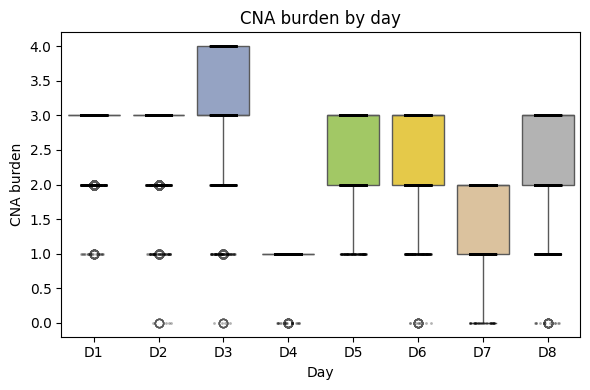

C:\Users\clark\AppData\Local\Temp\ipykernel_38244\2456935149.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.values, y=freq.index, palette='mako')


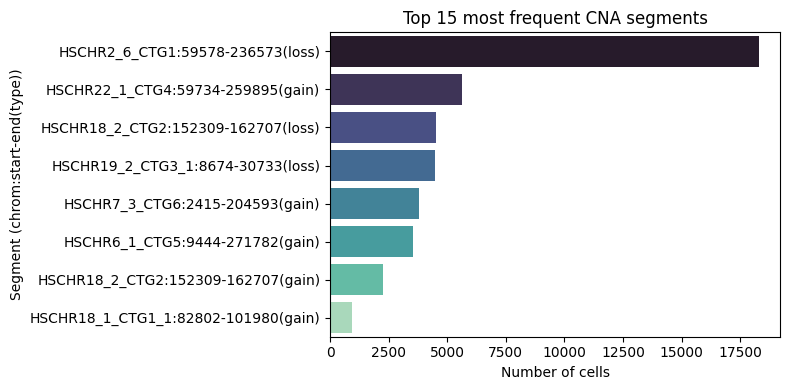

In [14]:

# assume cna_result7 is your combined AnnData from infer_cna_by_timepoint(...)
# and has:
#  - .obs['day']       the timepoint label
#  - .obs['cna_profile']  a string like "Chr1:100-200(gain);Chr3:500-800(loss)"
#  - .uns['cna_segments'] a list of segment dicts (chrom,start,end,type)

# 1) compute per‑cell burden (# of segments)
def count_segments(profile):
    if not profile:
        return 0
    return len(profile.split(';'))

burden = cna_result7.obs['cna_profile'].fillna('').map(count_segments)
cna_result7.obs['cna_burden'] = burden

# 2) plot global burden histogram
plt.figure(figsize=(6,4))
sns.histplot(burden, bins=np.arange(burden.max()+2)-0.5, kde=False)
plt.title("Per‑cell CNA burden (all cells)")
plt.xlabel("Number of segments called")
plt.ylabel("Number of cells")
plt.tight_layout()
plt.show()

# 3) plot burden by timepoint
plt.figure(figsize=(6,4))
sns.boxplot(data=cna_result7.obs, x='timepoint', y='cna_burden', palette='Set2')
sns.stripplot(data=cna_result7.obs, x='timepoint', y='cna_burden',
              color='k', size=2, alpha=0.3, jitter=0.2)
plt.title("CNA burden by day")
plt.xlabel("Day")
plt.ylabel("CNA burden")
plt.tight_layout()
plt.show()

# 4) most frequent CNA segments across all cells
#    explode all the profiles into one long list
all_segs = (
    cna_result7.obs['cna_profile']
      .dropna()
      .loc[lambda s: s != ""]
      .str.split(';')
      .explode()
)
freq = all_segs.value_counts().head(15)

plt.figure(figsize=(8,4))
sns.barplot(x=freq.values, y=freq.index, palette='mako')
plt.title("Top 15 most frequent CNA segments")
plt.xlabel("Number of cells")
plt.ylabel("Segment (chrom:start-end(type))")
plt.tight_layout()
plt.show()


To do list:

- update task 1 to use log2 ratio instead of z score (comment the lines where i have changed)
- task 2: use window of 40 and threshold of +/-0.15
- task 3: run code for dataset 1 and 2

# Using Housekeeping genes to test functionality

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define your housekeeping genes
housekeeping = [
    "ACTB", "GAPDH", "B2M", "RPLP0", "HPRT1",
    "PGK1", "TFRC", "RPL13A", "RPS18", "UBC"
]

# 2. Prepare diploid control using your helper
control = prepare_control(
    adata3,
    time_key='timepoint',
    ctrl_label='D0',
    min_genes=200,
    n_subsample=500
)

/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
# 3. Compute per-timepoint housekeeping log2-ratios
tp_labels = sorted(set(adata3.obs['timepoint']) - {'D0'})
hk_means = {}

for tp in tp_labels:
    print(f"[INFO] Processing timepoint {tp}")
    test = adata3[adata3.obs['timepoint'] == tp]

    # 3a. Compute sparse‑friendly Z
    Z = normalize_expr(test, control, method='log2_ratio')

    # 3b. Identify housekeeping columns
    hk_genes = [g for g in housekeeping if g in test.var_names]
    if not hk_genes:
        raise ValueError(f"No housekeeping genes found in var_names for timepoint {tp}")
    hk_idxs = [test.var_names.get_loc(g) for g in hk_genes]

    # 3c. Slice out housekeeping columns
    Z_hk = Z[:, hk_idxs]
    # If sparse, densify; if already dense, do nothing
    if hasattr(Z_hk, "toarray"):
        Z_hk = Z_hk.toarray()
    # Now Z_hk is an ndarray of shape (n_cells_tp, len(hk_genes))

    # 3d. Compute per-cell mean
    hk_means[tp] = Z_hk.mean(axis=1)

[INFO] Processing timepoint D10
[INFO] Processing timepoint D2
[INFO] Processing timepoint D4
[INFO] Processing timepoint D6
[INFO] Processing timepoint D8


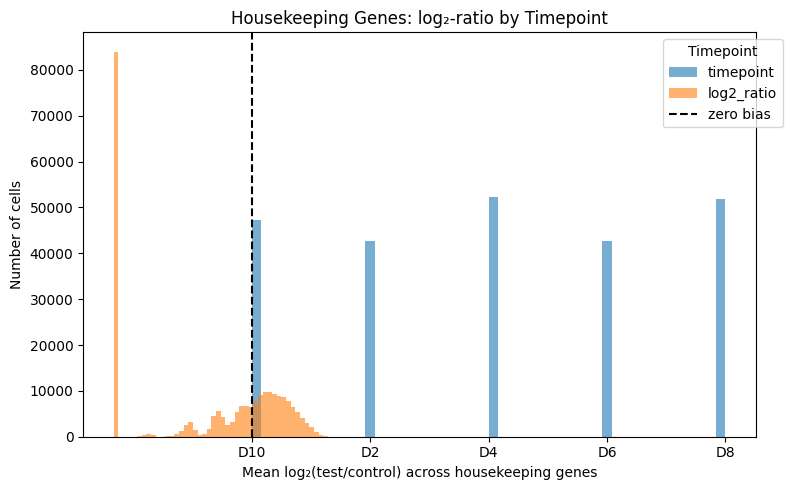

Housekeeping log₂‑ratio summary by timepoint:
D10  mean=-0.307  median=-0.015  5th=-1.166  95th=0.492
D2   mean=-0.422  median=-0.229  5th=-1.166  95th=0.253
D4   mean=-0.410  median=-0.136  5th=-1.166  95th=0.293
D6   mean=-0.411  median=-0.173  5th=-1.166  95th=0.340
D8   mean=-0.367  median=-0.103  5th=-1.166  95th=0.415


In [16]:
# Convert to long-form DataFrame
rows = []
for tp, arr in hk_means.items():
    for val in arr:
        rows.append({'timepoint': tp, 'log2_ratio': val})
hk_df = pd.DataFrame(rows)

# 5. Plot distributions per timepoint
plt.figure(figsize=(8, 5))
for tp in hk_df.columns:
    plt.hist(hk_df[tp], bins=50, alpha=0.6, label=tp)
plt.axvline(0, color='k', linestyle='--', label='zero bias')
plt.xlabel("Mean log₂(test/control) across housekeeping genes")
plt.ylabel("Number of cells")
plt.title("Housekeeping Genes: log₂‐ratio by Timepoint")
plt.legend(title='Timepoint', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()
print("Housekeeping log₂‑ratio summary by timepoint:")
for tp in sorted(hk_df['timepoint'].unique()):
    arr = hk_df.loc[hk_df['timepoint'] == tp, 'log2_ratio'].astype(float).dropna().values
    print(f"{tp:<4} mean={arr.mean():.3f}  median={np.median(arr):.3f}  "
          f"5th={np.percentile(arr,5):.3f}  95th={np.percentile(arr,95):.3f}")


## running inference on house keeping genes

In [18]:
housekeeping = [
    "ACTB", "GAPDH", "B2M", "RPLP0", "HPRT1",
    "PGK1", "TFRC", "RPL13A", "RPS18", "UBC"
]


In [19]:
hk_genes = [g for g in housekeeping if g in adata3.var_names]
adata3_hk = adata3[:, hk_genes].copy()


control_hk = prepare_control(adata3_hk, time_key='timepoint', ctrl_label='D0')
cna_results_hk = infer_cna_by_timepoint(adata3_hk, control_hk, gtf_df=None, time_key='timepoint', exclude=['D0'])


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:68: RuntimeWarning: Mean of empty slice.
  mu = Xc.mean(axis=0)
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

[INFO] Inferring CNAs for D10...
[INFO] Inferring CNAs for D2...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:68: RuntimeWarning: Mean of empty slice.
  mu = Xc.mean(axis=0)
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D4...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:68: RuntimeWarning: Mean of empty slice.
  mu = Xc.mean(axis=0)
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D6...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:68: RuntimeWarning: Mean of empty slice.
  mu = Xc.mean(axis=0)
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):


[INFO] Inferring CNAs for D8...


/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_544360/3615784739.py:68: RuntimeWarning: Mean of empty slice.
  mu = Xc.mean(axis=0)
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_544360/3615784739.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
/home/clark/anaconda3/envs/cscb/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_u

In [22]:
cna_results_hk.obs['cna_profile']

AACACACAGAACGTCCAAGCATTAGCA     
AACACACAGAACGTCCAAGTGTCTGAA     
AACACACAGAATCCGGTGAATTCTGGC     
AACACACAGACAACAGGTGTAACGCTT     
AACACACAGACACCAACGGATTGCGAG     
                              ..
TGTGGACACTTACACGACGCATTAGCA     
TGTGGACACTTCGAGGATCAGGAACCA     
TGTGGACACTTCGAGGATCCATATCTC     
TGTGGACACTTGAGACAGCTAGGTTGC     
TGTGGACACTTGAGACAGGGAGAGGAA     
Name: cna_profile, Length: 236863, dtype: object

The inference result in empty cna_profile, which means the genes are stable, and these house keeping genes are not affected by cnas